# Analyse network results for sector-coupled PyPSA-Earth

This notebook loads a solved PyPSA-Earth network (stored as a `.nc` file) and analyses the **sector-coupled** results.  
The code automatically searches and selects a network to analyse in the <results> folders based on the scenario configuration in `config.yaml`.

- `<results_dir>/<run_name>/networks/` for electricity-only runs  
- `<results_dir>/<sector_name>/postnetworks/` for sector-coupled runs

This notebook processes the latest optimization data specified in the config.yaml file and the network .nc file. It generates comprehensive plots and summaries to visualize the results.

Sources: 
- Statistics module: https://pypsa.readthedocs.io/en/latest/examples/statistics.html
- Templates and colors: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/network_analysis.ipynb

File is needed:
* PyPSA network file (.nc) includes the heating, transprot, and electricity demand information.

## Import packages

In [1]:
import yaml
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import os
import logging
import glob

## Settings

### Set project root

In [2]:
if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")

PARENT = os.path.realpath("pypsa-earth") + os.sep

### Load configuration

In [3]:
with open(os.path.join(PARENT, "config.yaml"), "r") as f:
    cfg = yaml.safe_load(f)

run = cfg.get("run", {}) or {}
scen = cfg.get("scenario", {}) or {}
costs = cfg.get("costs", {}) or {}
expo = cfg.get("export", {}) or {}

results_dir = (cfg.get("results_dir", "results/") or "results/").strip("/") + "/"

### Directory definitions

In [4]:
RDIR = (run.get("name") or "").strip()
RDIR = (RDIR + "/") if RDIR else ""

SECDIR = (run.get("sector_name") or "").strip()
SECDIR = (SECDIR + "/") if SECDIR else ""

elec_dir = os.path.join(PARENT, results_dir, RDIR, "networks")
sector_post_dir = os.path.join(PARENT, results_dir, SECDIR, "postnetworks")
sector_pre_dir = os.path.join(PARENT, results_dir, SECDIR, "prenetworks")

### Wildcard helper

In [5]:
def pick(val, allow_empty=False):
    """
    Return single value if exactly one is given.
    Return '*' if multiple values or empty (unless allow_empty=True).
    """
    if val is None:
        return "*"
    if isinstance(val, (list, tuple)):
        if len(val) == 1:
            s = "" if val[0] is None else str(val[0])
            return s if (allow_empty or s != "") else "*"
        return "*"
    s = "" if val is None else str(val)
    return s if (allow_empty or s != "") else "*"

### Build wildcard segments

In [6]:
simpl = pick(scen.get("simpl", [""]), allow_empty=True)
clusters = pick(scen.get("clusters"))
ll = pick(scen.get("ll"))
opts = pick(scen.get("opts"))
sopts = pick(scen.get("sopts", [""]), allow_empty=True)
plan = pick(scen.get("planning_horizons"))
dr = pick(costs.get("discountrate"))
demand = pick(scen.get("demand"))

h2_raw = pick(expo.get("h2export"))
h2 = (h2_raw + "export") if h2_raw != "*" else "*export"

### Pattern builders

In [7]:
def post_pattern(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    return os.path.join(sector_post_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")

def pre_patterns(include_sopts=True):
    core = f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}"
    tail = f"_{sopts}" if (include_sopts and sopts not in ("",)) else ""
    with_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}_{h2}.nc")
    no_export = os.path.join(sector_pre_dir, f"{core}{tail}_{plan}_{dr}_{demand}.nc")
    return [with_export, no_export]

patterns = [
    post_pattern(include_sopts=True),
    post_pattern(include_sopts=False),
    *pre_patterns(include_sopts=True),
    *pre_patterns(include_sopts=False),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}.nc"),
    os.path.join(elec_dir, f"elec_s{simpl}_{clusters}_ec_l{ll}_{opts}_*.nc"),
]

### Find networks

In [8]:
all_matches = []
for pat in patterns:
    all_matches.extend(glob.glob(pat))

# remove duplicates
all_matches = sorted(set(all_matches), key=os.path.getmtime)

if not all_matches:
    recent = sorted(
        glob.glob(os.path.join(PARENT, results_dir, "**", "*.nc"), recursive=True),
        key=os.path.getmtime
    )[-20:]
    recent_txt = "\n".join(os.path.relpath(p, PARENT) for p in recent) or "(none)"
    raise FileNotFoundError(
        "No network matched.\n"
        "Here are the last few .nc files under results/:\n"
        f"{recent_txt}"
    )

print("Found networks:")
for m in all_matches:
    print("-", os.path.relpath(m, PARENT))

Found networks:
- results/postnetworks/elec_s_24_ec_lcopt_Co2L-3h_144h_2030_0.071_AB_10export.nc


### Network Setup

In [9]:
logging.getLogger("pypsa.io").setLevel(logging.ERROR) # ignore warnings

chosen = all_matches[-1]  # choose newest one
print("\nOpening newest match:", os.path.relpath(chosen, PARENT), "\n")
n = pypsa.Network(chosen)


Opening newest match: results/postnetworks/elec_s_24_ec_lcopt_Co2L-3h_144h_2030_0.071_AB_10export.nc 



## Data import check

List number of components by type

In [10]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 604 entries
Component 'Carrier' has 134 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 26 entries
Component 'LineType' has 35 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 1576 entries
Component 'Load' has 731 entries
Component 'Generator' has 914 entries
Component 'StorageUnit' has 2 entries
Component 'Store' has 411 entries


List the snapshots of the PyPSA network

In [11]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01', '2013-01-07', '2013-01-13', '2013-01-19',
               '2013-01-25', '2013-01-31', '2013-02-06', '2013-02-12',
               '2013-02-18', '2013-02-24', '2013-03-02', '2013-03-08',
               '2013-03-14', '2013-03-20', '2013-03-26', '2013-04-01',
               '2013-04-07', '2013-04-13', '2013-04-19', '2013-04-25',
               '2013-05-01', '2013-05-07', '2013-05-13', '2013-05-19',
               '2013-05-25', '2013-05-31', '2013-06-06', '2013-06-12',
               '2013-06-18', '2013-06-24', '2013-06-30', '2013-07-06',
               '2013-07-12', '2013-07-18', '2013-07-24', '2013-07-30',
               '2013-08-05', '2013-08-11', '2013-08-17', '2013-08-23',
               '2013-08-29', '2013-09-04', '2013-09-10', '2013-09-16',
               '2013-09-22', '2013-09-28', '2013-10-04', '2013-10-10',
               '2013-10-16', '2013-10-22', '2013-10-28', '2013-11-03',
               '2013-11-09', '2013-11-15', '2013-11-21', '2013-11-27',
      

## Analyse energy system

### Transport Sector 
The demand of EVs, ICE (internal combustion engine) and FCEV (fuell cell)

In [12]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
transport_stats_GWh = load_stats[load_stats.index.get_level_values('carrier').str.contains(
    'land transport oil(?! emissions)|land transport fuel cell|land transport EV', 
    case=True)]
transport_stats_GWh

component  carrier                   bus_carrier     
Load       land transport EV         Li ion             -7.768924e+05
           land transport fuel cell  Hydrogen Storage   -1.564629e+06
           land transport oil        oil                -2.555561e+08
Name: objective, dtype: float64

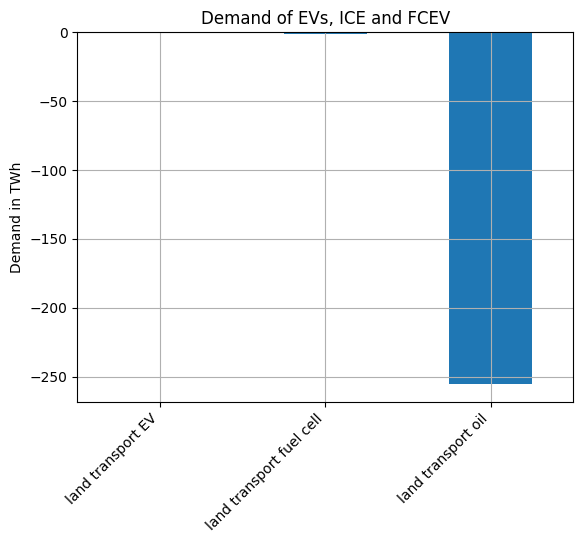

In [13]:
transport_stats_TWh = transport_stats_GWh/1000000

ax = transport_stats_TWh.plot.bar(
    title='Demand of EVs, ICE and FCEV',
    xlabel="",
    ylabel="Demand in TWh"
)

ax.set_xticklabels(transport_stats_GWh.index.get_level_values('carrier'), rotation=45, ha="right")
ax.grid(True) 
plt.show()

### Heating Sector 
The demand of various heating subsectors

In [14]:
load_stats = n.statistics.energy_balance(comps=["Load"], aggregate_time="sum")
heating_stats_GWh = load_stats[load_stats.index.get_level_values('carrier').str.contains('heat', case=False)]
heating_stats_GWh

component  carrier                           bus_carrier                     
Load       residential rural heat            residential rural heat             -1.439013e+05
           residential urban decentral heat  residential urban decentral heat   -1.505814e+05
           urban central heat                urban central heat                 -1.210003e+06
Name: objective, dtype: float64

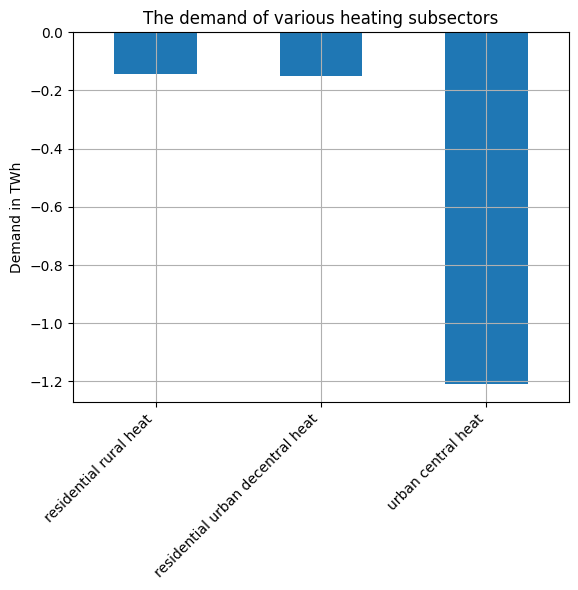

In [15]:
heating_stats_TWh = heating_stats_GWh/1000000

ax = heating_stats_TWh.plot.bar(
    title='The demand of various heating subsectors',
    xlabel="",
    ylabel="Demand in TWh"
)

ax.set_xticklabels(heating_stats_TWh.index.get_level_values('carrier'), rotation=45, ha="right")
ax.grid(True)
plt.show()

How is heating energy supplied (heat pump, district heating, resistive heater, gas boiler)

Gas Boiler: 3990.01724 MWh
Heat Pump: 1407208.8072499998 MWh
Resistive Heater: 50442.63518999999 MWh
CHP: 57864.779839999996 MWh


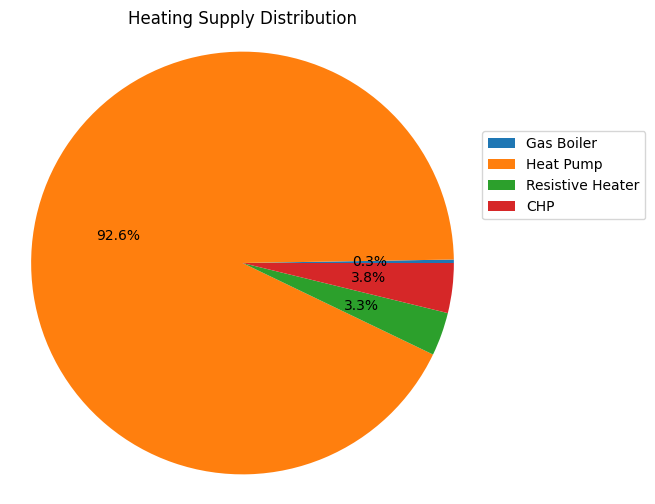

In [16]:
heating_supply_stats = n.statistics.supply(comps=["Link"], aggregate_time="sum").loc[
    lambda x: x.index.get_level_values('carrier').str.contains('heat|boiler|pump|chp', case=False)
]

# Only the Gas boiler, heat pump, CHP, and resistive heater technologies are considered here
heating_types = ['Gas Boiler', 'Heat Pump', 'Resistive Heater', 'CHP']
heating_sums = [heating_supply_stats[heating_supply_stats.index.get_level_values('carrier').str.contains(heatingtype, case=False)].sum() for heatingtype in heating_types]

for ht, sum_value in zip(heating_types, heating_sums):
    print(f"{ht}: {sum_value} MWh")

plt.figure(figsize=(6, 6))
plt.pie(heating_sums, autopct='%1.1f%%')
plt.title('Heating Supply Distribution')
plt.legend(heating_types, loc='upper left', bbox_to_anchor=(1, 0.8))
plt.axis('equal')
plt.show()

### Electricity Sector 
The share of different carriers (capacity and energy)

In [17]:
def color_matching(stats):
    colors = {key.lower(): value.lower() for key, value in cfg["plotting"]["tech_colors"].items()}
    nice_names = {value.lower(): key for key, value in cfg["plotting"]["nice_names"].items()}
    color_list = []
    for carrier in stats.index.get_level_values("carrier"):
        original_name = carrier.lower()
        key_name = nice_names.get(original_name, original_name)
        color = colors.get(key_name.lower(), 'gray')
        color_list.append(color)
    return color_list

In [18]:
capacity_stats = n.statistics.installed_capacity(comps=["Generator"])
# Remove carrier with the capacity = 0
capacity_stats_non_zero = capacity_stats[capacity_stats != 0].dropna()
capacity_stats_plus = n.statistics.installed_capacity(comps=["StorageUnit"])
combined_capacity_stats = pd.concat([capacity_stats_non_zero, capacity_stats_plus])
combined_capacity_stats

component    carrier           
Generator    Combined-Cycle Gas    13826.94804
             Load shedding         66396.83563
             Solar                   136.62160
StorageUnit  Reservoir & Dam        2638.00000
Name: p_nom, dtype: float64

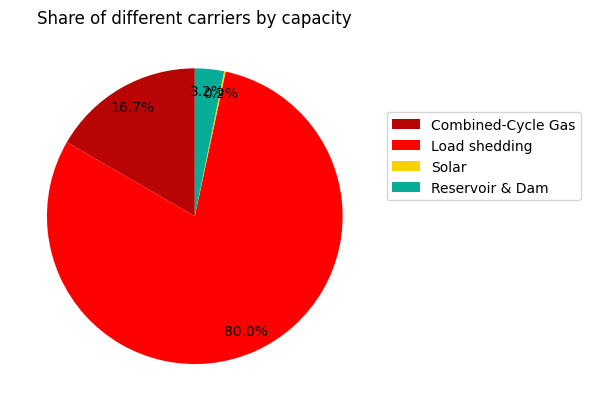

In [19]:
color_list = color_matching(combined_capacity_stats)

combined_capacity_stats.plot.pie(
    title="Share of different carriers by capacity",
    labels=None,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    ylabel="",
    colors=color_list,
)

custom_labels = combined_capacity_stats.index.get_level_values("carrier")
plt.legend(custom_labels, loc='upper left', bbox_to_anchor=(1, 0.8))


In [20]:
energy_stats = n.statistics.energy_balance(comps=["Generator"])
electricity_energy_stats = energy_stats[energy_stats.index.get_level_values('bus_carrier') == 'AC']
electricity_energy_stats_plus = n.statistics.energy_balance(comps=["StorageUnit"])
combined_electricity_energy_stats = pd.concat([electricity_energy_stats, electricity_energy_stats_plus])
combined_electricity_energy_stats

component    carrier          bus_carrier
StorageUnit  Reservoir & Dam  Ac             5.220270e+06
dtype: float64

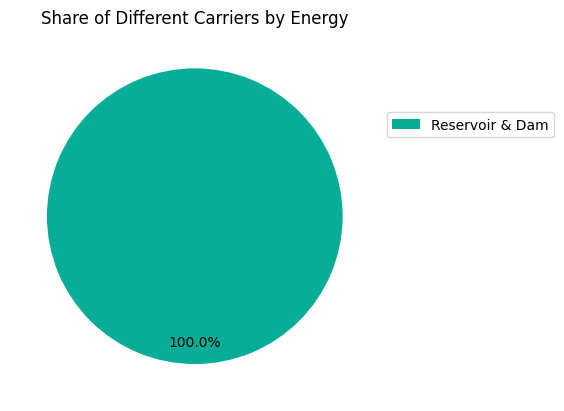

In [21]:
color_list = color_matching(combined_electricity_energy_stats)

combined_electricity_energy_stats.plot.pie(
    title='Share of Different Carriers by Energy',
    labels=None,
    autopct='%1.1f%%',
    pctdistance=0.85,
    startangle=90,
    ylabel="",
    colors=color_list,  
)

custom_labels = combined_electricity_energy_stats.index.get_level_values("carrier")
plt.legend(custom_labels, loc='upper left', bbox_to_anchor=(1, 0.8))